In [139]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime
from keras import regularizers
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split

In [140]:
# Configure kaggle
os.chdir('/root/')
!mkdir -p .kaggle
os.chdir('/root/.kaggle')
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Y-o0TVcjehM8SZB3Nt8U3xkyeQu-Nse-' -O kaggle.json > /dev/null 2>&1
!ls /root/.kaggle

# Set permissions 
!chmod 600 /root/.kaggle/kaggle.json

# Create data folder
os.chdir('/content/')
!rm -rf data
!mkdir data
os.chdir('data')
!pwd

# Download data
!pip install -q kaggle
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge
!pwd
!ls
# Unzip data
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip train.csv

kaggle.json
/content/data
 97% 278M/285M [00:02<00:00, 121MB/s]
100% 285M/285M [00:02<00:00, 107MB/s]
/content/data
challenges-in-representation-learning-facial-expression-recognition-challenge.zip
Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: train.csv               


In [141]:
data = pd.read_csv('train.csv')
print(data.head(5))

   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [142]:
import csv
import numpy

train_images = []
train_labels = []

categories_count = {}

with open('train.csv') as train:

    # Read train.csv file
    csv_reader = csv.reader(train)
    
    next(csv_reader)  # Skip the header

    for row in csv_reader:

        # Append image
        pixels_str = row[1]
        pixels_list = [int(i) for i in pixels_str.split(' ')]
        pixels_list = numpy.array(pixels_list, dtype='uint8')
        image = pixels_list.reshape((48, 48))
        train_images.append(image)

        label_str = row[0]

        # Calculate categories count
        count = 0
        if label_str in categories_count:
            count = categories_count[label_str] + 1
        categories_count[label_str] = count

        # Append label
        label = int(label_str)
        train_labels.append(label)

# Create numpy array of train images and labels
x_train = numpy.array(train_images)
y_train = numpy.array(train_labels)

print('x_train shape: {0}'.format(x_train.shape))
print('y_train shape: {0}'.format(y_train.shape))

x_train shape: (28709, 48, 48)
y_train shape: (28709,)


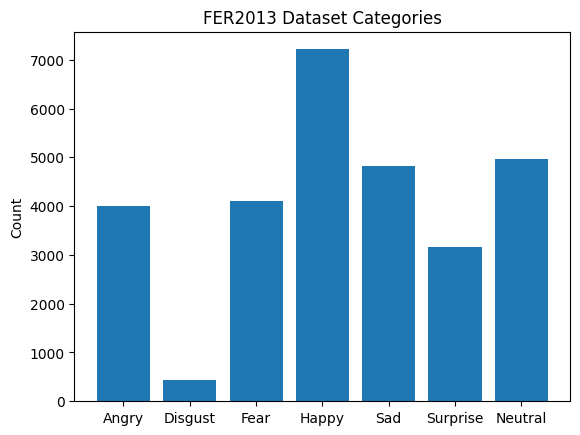

In [143]:
categories = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')
y_pos = numpy.arange(len(categories))

counts = []
for label in range(len(categories)):
    label_str = str(label)
    count = categories_count[label_str]
    counts.append(count)

# Draw histogram
plt.bar(y_pos, counts, align='center')
plt.xticks(y_pos, categories)
plt.ylabel('Count')
plt.title('FER2013 Dataset Categories')

plt.show()

In [144]:

# Split dataset into train set and test set
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.reshape(len(x_train), 48, 48, 1)
x_test = x_test.reshape(len(x_test), 48, 48, 1)

print(x_train.shape)
print(x_test.shape)

(22967, 48, 48, 1)
(5742, 48, 48, 1)


In [145]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [146]:
import keras_tuner
from tensorflow import keras  

In [147]:
def build_model(hp):
  model = keras.Sequential()
  model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape = (48, 48,1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

  model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

  model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

  model.add(Flatten())
  model.add(Dense(units = hp.Int('dense_1_unit',min_value=32,max_value=128,step=16),activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(units = hp.Int('dense_2_unit',min_value=32,max_value=128,step=16),activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(7,activation='softmax'))
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),loss='sparse_categorical_crossentropy',metrics =['accuracy'])
  return model
  

In [149]:
build_model(keras_tuner.HyperParameters())

In [150]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="emojination",
)

In [151]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
dense_1_unit (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
dense_2_unit (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [152]:
tuner.search(x_train, y_train, epochs=2, validation_split=0.2)

Trial 3 Complete [00h 00m 38s]
val_accuracy: 0.42718763649463654

Best val_accuracy So Far: 0.434479758143425
Total elapsed time: 00h 02m 16s


In [153]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 21, 21, 32)       128       
 hNormalization)                                                 
                                                        

In [154]:
tuner.results_summary()


Results summary
Results in my_dir/emojination
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
dense_1_unit: 128
dense_2_unit: 96
lr: 0.00038233309331929153
Score: 0.434479758143425

Trial 1 summary
Hyperparameters:
dense_1_unit: 128
dense_2_unit: 96
lr: 0.0021976602707665946
Score: 0.4335002154111862

Trial 2 summary
Hyperparameters:
dense_1_unit: 32
dense_2_unit: 48
lr: 0.0004584268052227718
Score: 0.42718763649463654


In [155]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0000001,
    patience=0,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [156]:
history = model.fit(x_train,y_train,epochs=10,validation_split =0.2,callbacks=callback)

Epoch 1/10
575/575 [==============================] - 7s 12ms/step - loss: 0.7916 - accuracy: 0.7608 - val_loss: 0.8268 - val_accuracy: 0.7403
Epoch 2/10
575/575 [==============================] - 9s 16ms/step - loss: 0.5363 - accuracy: 0.8225 - val_loss: 0.7704 - val_accuracy: 0.7564
Epoch 3/10
575/575 [==============================] - 9s 15ms/step - loss: 0.4373 - accuracy: 0.8545 - val_loss: 0.9143 - val_accuracy: 0.7281
Epoch 3: early stopping


In [157]:
y_prob =model.predict(x_test)

180/180 [==============================] - 2s 9ms/step


In [158]:
y_pred=y_prob.argmax(axis=1)

In [159]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.7129919888540578

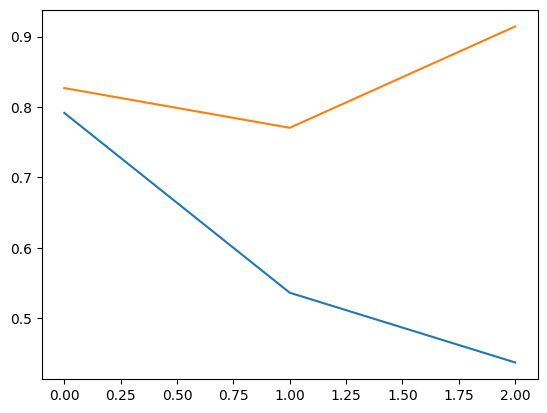

In [160]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

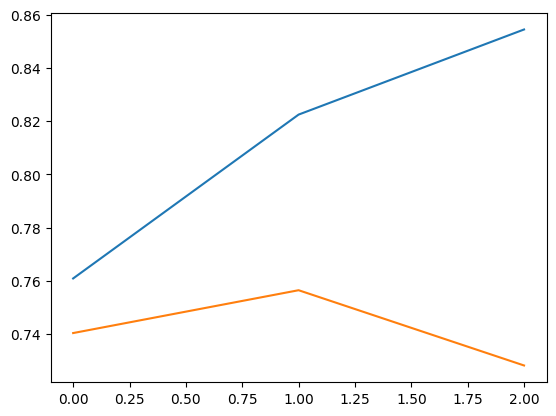

In [161]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])